# Tutorial 2: Gaussian process regression in BoTorch and gpytorch
### (with solutions to exercises)

BoTorch is a package for Bayesian Optimization.  Its support for Gaussian process regression comes from another package, gpytorch.  Both of these packages are, in turn, based on pytorch, which is a framework often used for deep learning that supports fast operations on GPUs in python and autodifferentiation. Both of these features are also useful in Bayesian optimization.

Here we'll use these packages to do the same inference that we did in Tutorial 1, but more quickly and with more capabilities.

To run this notebook, you'll need to first install botorch. You can do this via pip or conda, depending on which you like to use to manage your packages. Installing botorch will also install torcch.
- To install via Anaconda: `conda install botorch -c pytorch -c gpytorch`
- To install via pip: `pip install botorch`


This tutorial is based on the BoTorch tutorial, https://botorch.org/tutorials/fit_model_with_torch_optimizer, which is based on the gpytorch tutorial, https://github.com/cornellius-gp/gpytorch/blob/master/examples/01_Exact_GPs/Simple_GP_Regression.ipynb

In [10]:
import torch # loading torch before matplotlib can be important
import matplotlib.pyplot as plt
import math
import numpy as np
import os.path

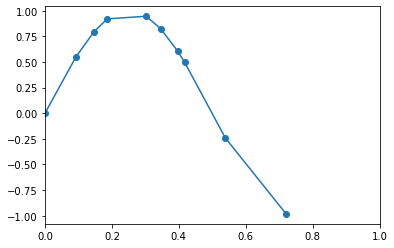

In [11]:
filename = 'lab1_data.csv'
data = np.loadtxt(filename)
train_x = data[:,0] # First column of the data
train_y = data[:,1] # Second column of the data
plt.xlim(0,1)
plt.plot(train_x, train_y,'o-')

In [12]:
# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

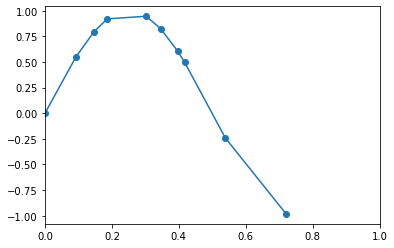

In [13]:
# Read in data from a file.  Code copied from Lab 1. When you run this notebook, to reproduce the results,
# download lab1_data.csv from the repository rather than having this cell re-generate it for you.
filename = 'lab1_data.csv'

# If data doesn't exist, generate it
if ~os.path.exists(filename):
    np.random.seed(1)
    train_x = np.sort(np.random.rand(10)) # 10 points, uniformly distributed between 0 and 1
    train_y = [math.sin(x * (2 * math.pi)) + 0.0 * np.random.randn() for x in train_x]
    data = np.transpose([train_x,train_y])
    np.savetxt(filename,data)

# Read in data from a file.  
data = np.loadtxt(filename)
train_x = data[:,0] # First column of the data
train_y = data[:,1] # Second column of the data
plt.xlim(0,1)
plt.plot(train_x, train_y,'o-')

### Convert training data to torch format

In [14]:
# Convert our training x and y data to torch format.
# To do this, we first convert to a torch tensor.
# Then we use unsqueeze to make the tensors multidimensional.
# Note that we are changing the datatype of train_x and train_y
train_x = torch.from_numpy(train_x).unsqueeze(1)
train_y = torch.from_numpy(train_y).unsqueeze(1)

# Outputting one of these tensors to show what they look like
train_x

tensor([[1.1437e-04],
        [9.2339e-02],
        [1.4676e-01],
        [1.8626e-01],
        [3.0233e-01],
        [3.4556e-01],
        [3.9677e-01],
        [4.1702e-01],
        [5.3882e-01],
        [7.2032e-01]], dtype=torch.float64)

### Train the GP regression model and plot the posterior
We will model the function using a `SingleTaskGP`. Here, "single task" refers to the fact that the funcction we are modeling with a GP has a scalar output. BoTorch is also able to model functions with vector-valued outputs, for which it uses something called a "multi-task GP".

The `SingleTaskGP` has a `likelihood` argument, which describes the likelihood of our observation y(x) conditioned on the fuction's underlying value at x. This lets us model noisy observations. Here, we pass a `FixedNoiseGaussianLikelihood`, which assumes that all of the observations are independent and normally distributed with known variance around the function's true value, conditioned on the underlying function itself. BoTorch is also able to use other kinds of likelihoods.

In [15]:
from botorch.models import SingleTaskGP
from gpytorch.constraints import GreaterThan
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood

# Create a likelihood appropriate for noise-free observations.
# We will use a Gaussian likelihood with a very small variance (noisefree_variance).
# This variance is passed as a torch tensor with one entry per datapoint, and all
# entries containing the same value.
# We use a small strictly positive variance instead of zero variance
# to avoid numerical instabilities. If, instead, we set noisefree_variance to 0, 
# then gpytorch issues warning messages and rounds up to a small positive number
# (at least in June 2022 when this part of the tutorial was developed).
noisefree_variance = 0.0001
noises = torch.ones(len(train_y)) * noisefree_variance
noise_free_likelihood = FixedNoiseGaussianLikelihood(noise=noises)

# Create our GP model using the training data. By default, BoTorch uses a constant mean and Matern kernel.
model = SingleTaskGP(train_x, train_y, likelihood = noise_free_likelihood)

# Another slightly faster way to do the same thing is:
# from botorch.models import FixedNoiseGP
# model = SingleTaskGP(train_x, train_y, likelihood = noise_free_likelihood)

# If you want to allow BoTorch to learn the variance of homoscedastic Gaussian noise, 
# drop the likelihood argument:
# model = FixedNoiseGP(torch_train_x, torch_train_y, noises)

model # Print out the model object

SingleTaskGP(
  (likelihood): FixedNoiseGaussianLikelihood(
    (noise_covar): FixedGaussianNoise()
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
)

You can see from the output above that the GP model has several components:
- a likelihood, described above
- a mean and covar module, which specifies the mean and kernel function respectively

The covar module has a constraint on its lengthscale saying that it must be positive, and also has a prior that is used when estimating it from data.  For now, we will simply use a fixed length scale and so this constraint and prior won't matter for the moment.

Now we change the parameters used in the prior to match what we used in Tutorial 1 as a default.  The constant for the mean because it is 0 by default. Then we can fit the model and see that BoTorch is doing the same thing that our pure-python GP regression code did earlier.

In [16]:
# Change the mean function. To do so, we have to construct a neural network parameter
# from the desired value (0), rather than simply setting the constant to 0.
model.mean_module.constant = torch.nn.Parameter(torch.tensor(0.)) 

# Now we will change 3 parameters in the Matern kernel: nu, the length scale, and the output scale.

# Change the parameter nu (this is the same parameter nu that we saw in Tutorial 1). 
# gpytorch only supports some values for this parameter: 1/2, 3/2, or 5/2.
# If you want to use the value 2, use the RBF Kernel instead,
# since the the RBF kernel is the Matern kernel with nu=2.
model.covar_module.base_kernel.nu = 1.5

# Change the length scale.
# base_kernel.lengthscale is what we call length_scale in Lab 1 and what we call alpha_1 in the slides.
# It determines the length scale of the output.
model.covar_module.base_kernel.lengthscale = 1.

# Change the output scale.
# model.covar_module.outputscale is what we call alpha0 in our Lab 1 code.  
model.covar_module.outputscale = 1.

# Train the GP model
model.eval()

SingleTaskGP(
  (likelihood): FixedNoiseGaussianLikelihood(
    (noise_covar): FixedGaussianNoise()
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
)

/usr/local/anaconda3/lib/python3.7/site-packages/gpytorch/lazy/lazy_tensor.py:1810: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1656352443756/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


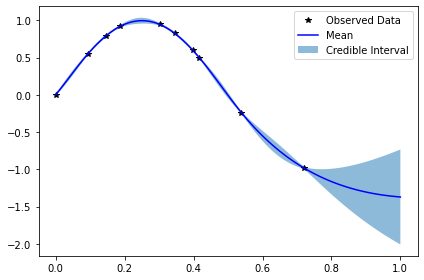

In [17]:
# This code used the trained GP model to plot the posterior.
# Its output should match the plot we made in Tutorial 1.
# It may produce a warning message about torch.triangular_solve being deprecated. Don't worry about this.
def plot_posterior(model):

    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(6, 4))
    # test model on 101 regular spaced points on the interval [0, 1]
    test_x = torch.linspace(0, 1, 101, dtype=dtype, device=device)

    with torch.no_grad(): # no need for gradients
        # compute posterior
        posterior = model.posterior(test_x)
        # Get upper and lower confidence bounds (2 standard deviations from the mean)
        lower, upper = posterior.mvn.confidence_region()
        # Plot training points as black stars
        ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*')
        # Plot posterior means as blue line
        ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
        
    ax.legend(['Observed Data', 'Mean', 'Credible Interval'])
    plt.tight_layout()
    
plot_posterior(model)

You should see that this plot matches very closely with the plot that we got in Lab 1 using the default parameters:

`plot_prediction()`

#### Exercise 1

This exercise gives some practice changing the mean function and kernel that BoTorch uses.


Using BoTorch, reproduce the figure that you generated in Lab 1 with this code:

`plot_prediction(
    mean = lambda x : -0.5,
    kernel = lambda x1,x2 : matern(x1,x2, alpha0=20, length_scales=1.0, nu = 1.5))`

#### Exercise 1 Solution

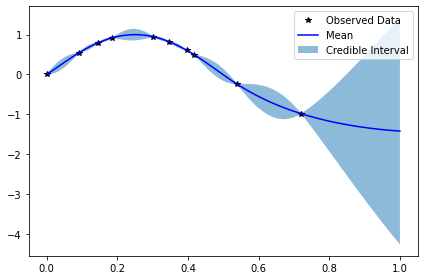

In [18]:
model = SingleTaskGP(train_x, train_y, likelihood = noise_free_likelihood)

model.mean_module.constant = torch.nn.Parameter(torch.tensor(-0.5)) 
model.covar_module.base_kernel.nu = 1.5
model.covar_module.base_kernel.lengthscale = 1.
model.covar_module.outputscale = 20.

# Train the GP model
model.eval()

plot_posterior(model)

# Choosing the GP hyperparameters

Practitioners don't usually set the parameters of the mean function and kernel (called hyperparameters) directly. Instead, there are two main approaches. Here we follow the simpler of the two, which is to set 
them so that the maximize how likely the data is under the model. We do this by asking BoTorch to calculate and then maximize the log marginal likelihood (the marginal likelihood is the prior probability of the data, marginalizing out the value of the function modeled at unobserved points).

### A detailed approach to setting the hyperparameters
Here we will show you how to do this manually, explaining all of the steps, and then below we'll show a function that does all of this for you. 

#### Start with a fresh Gaussian process, that doesn't have the parameters we set above

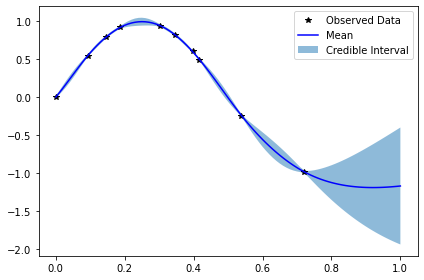

In [19]:
model = SingleTaskGP(train_x, train_y, likelihood = noise_free_likelihood)
model.covar_module.base_kernel.nu = 1.5
model.eval();

plot_posterior(model)

#### Define marginal log likelihood  (mll)

In [20]:
from gpytorch.mlls import ExactMarginalLogLikelihood

mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)

# set mll and all submodules to the numeric data type and device (GPU vs. CPU) specified at the start of 
# our BoTorch code.
mll = mll.to(train_x)

#### Define optimizer and specify hyperparameters to optimize
We will use stochastic gradient descent (`torch.optim.SGD`) to optimize the hyperparameters. In this example, we will use a simple fixed learning rate of 0.2, but in practice the learning rate may need to be adjusted. We will optimize over all parameters in the model, though one could pass a subset of the parameters to the model to tune only those while leaving the others fixed.

In [21]:
from torch.optim import SGD

optimizer = SGD([{'params': model.parameters()}], lr=0.2)

The following code allows us to look at the names of the parameters in the GP regression model that will be optimized.  Note that the 
outputscale and lengthscale are outputted with a "raw" prepended to them.  gpytorch wants to ensure that certaint parameters (like the lengthscale and outputscale) satisfy constraints (specifially, that they are positive). To do this, it maintains a raw version of these parameters that can be any real number, and a transformed version that satisfies the constraint.  For example, to satisfy a non-negativity constraint, one can have the transformed version be exp() applied to the raw parameter.  The parameter nu is not included in the parameters that BoTorch optimizes.

In [22]:
print('These are the parameters we will optimize over:')
for param_name, param in model.named_parameters():
    print(param_name)

These are the parameters we will optimize over:
mean_module.constant
covar_module.raw_outputscale
covar_module.base_kernel.raw_lengthscale


#### Optimize hyperparameters
Now we are ready to write our optimization loop. We will perform 1500 epochs of stochastic gradient descent using our entire training set.

In [23]:
NUM_EPOCHS = 1500

model.train()

for epoch in range(NUM_EPOCHS):
    # clear gradients
    optimizer.zero_grad()
    # forward pass through the model to obtain the output MultivariateNormal
    output = model(train_x)
    # Compute the negative marginal log likelihood
    loss = - mll(output, model.train_targets)
    # Use backward propagation to update the model's 
    loss.backward()
    # print every 10 iterations
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Negative Marginal Log Likelihood : {loss.item():>4.3f} "
            f"lengthscale: {model.covar_module.base_kernel.lengthscale.item():>4.3f} " 
            f"constant: {model.mean_module.constant.item():>4.3f} "
            f"outputscale: {model.covar_module.outputscale.item():>4.3f}" 
         )
    optimizer.step()

Epoch  10/1500 - Negative Marginal Log Likelihood : -0.088 lengthscale: 0.515 constant: -0.184 outputscale: 0.836
Epoch  20/1500 - Negative Marginal Log Likelihood : -0.100 lengthscale: 0.529 constant: -0.305 outputscale: 0.893
Epoch  30/1500 - Negative Marginal Log Likelihood : -0.108 lengthscale: 0.543 constant: -0.390 outputscale: 0.944
Epoch  40/1500 - Negative Marginal Log Likelihood : -0.113 lengthscale: 0.554 constant: -0.452 outputscale: 0.990
Epoch  50/1500 - Negative Marginal Log Likelihood : -0.117 lengthscale: 0.564 constant: -0.500 outputscale: 1.033
Epoch  60/1500 - Negative Marginal Log Likelihood : -0.119 lengthscale: 0.573 constant: -0.537 outputscale: 1.072
Epoch  70/1500 - Negative Marginal Log Likelihood : -0.122 lengthscale: 0.581 constant: -0.567 outputscale: 1.109
Epoch  80/1500 - Negative Marginal Log Likelihood : -0.123 lengthscale: 0.588 constant: -0.591 outputscale: 1.143
Epoch  90/1500 - Negative Marginal Log Likelihood : -0.125 lengthscale: 0.594 constant: 

Epoch 750/1500 - Negative Marginal Log Likelihood : -0.132 lengthscale: 0.667 constant: -0.791 outputscale: 1.613
Epoch 760/1500 - Negative Marginal Log Likelihood : -0.132 lengthscale: 0.668 constant: -0.791 outputscale: 1.614
Epoch 770/1500 - Negative Marginal Log Likelihood : -0.132 lengthscale: 0.668 constant: -0.791 outputscale: 1.614
Epoch 780/1500 - Negative Marginal Log Likelihood : -0.132 lengthscale: 0.668 constant: -0.791 outputscale: 1.614
Epoch 790/1500 - Negative Marginal Log Likelihood : -0.132 lengthscale: 0.668 constant: -0.791 outputscale: 1.615
Epoch 800/1500 - Negative Marginal Log Likelihood : -0.132 lengthscale: 0.668 constant: -0.791 outputscale: 1.615
Epoch 810/1500 - Negative Marginal Log Likelihood : -0.132 lengthscale: 0.668 constant: -0.791 outputscale: 1.616
Epoch 820/1500 - Negative Marginal Log Likelihood : -0.132 lengthscale: 0.668 constant: -0.791 outputscale: 1.616
Epoch 830/1500 - Negative Marginal Log Likelihood : -0.132 lengthscale: 0.668 constant: 

In [24]:
# set model (and likelihood)
model.eval()

SingleTaskGP(
  (likelihood): FixedNoiseGaussianLikelihood(
    (noise_covar): FixedGaussianNoise()
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
)

lengthscale: 0.669 constant: -0.793 outputscale: 1.622 nu:  1.5


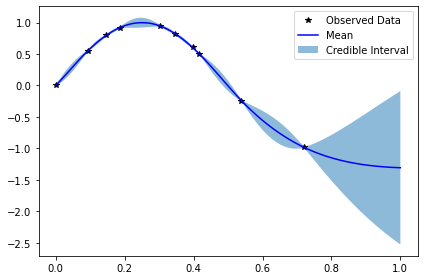

In [25]:
plot_posterior(model)
print(
    f"lengthscale: {model.covar_module.base_kernel.lengthscale.item():>4.3f} " 
    f"constant: {model.mean_module.constant.item():>4.3f} "
    f"outputscale: {model.covar_module.outputscale.item():>4.3f} " 
    f"nu: {model.covar_module.base_kernel.nu:>4.1f}"
)

### A faster way to set the hyperparameters
This uses a BoTorch helper function, `fit_gpytorch_model`, that isn't in gpytorch

In [26]:
from botorch.fit import fit_gpytorch_model
model = SingleTaskGP(train_x, train_y, likelihood = FixedNoiseGaussianLikelihood(noise=noises))
model.covar_module.base_kernel.nu = 1.5
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll) # This chooses the hyperparameters to maximize the log marginal likelihood

ExactMarginalLogLikelihood(
  (likelihood): FixedNoiseGaussianLikelihood(
    (noise_covar): FixedGaussianNoise()
  )
  (model): SingleTaskGP(
    (likelihood): FixedNoiseGaussianLikelihood(
      (noise_covar): FixedGaussianNoise()
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

lengthscale: 0.669 constant: -0.793 outputscale: 1.622 nu:  1.5


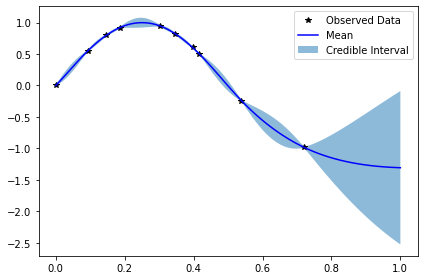

In [27]:
plot_posterior(model)
print(
    f"lengthscale: {model.covar_module.base_kernel.lengthscale.item():>4.3f} " 
    f"constant: {model.mean_module.constant.item():>4.3f} "
    f"outputscale: {model.covar_module.outputscale.item():>4.3f} " 
    f"nu: {model.covar_module.base_kernel.nu:>4.1f}"
)

# Cross-validation
The following code shows how to make the same cross-validation plots that we made in Tutorial 1 to check for model fit, but using BoTorch.

In [28]:
# Helper function for cross-validation
def remove(T,i):
    # Remove the ith component from the 1-dimensional tensor T
    assert(i<len(T))
    return torch.cat([T[:i], T[i+1:]])

# Check that we handle the two corner cases where i is 0 or len-1
assert(len(remove(train_x,0))==9)
assert(len(remove(train_x,len(train_x)-1))==9)
assert(len(remove(train_x,5))==9)

In [29]:
# Example of the helper function
remove(train_y,1)

tensor([[ 7.1864e-04],
        [ 7.9687e-01],
        [ 9.2087e-01],
        [ 9.4643e-01],
        [ 8.2510e-01],
        [ 6.0409e-01],
        [ 4.9807e-01],
        [-2.4148e-01],
        [-9.8267e-01]], dtype=torch.float64)

In [30]:
def cross_validation(train_x,train_y,nu=1.5):
    loo_mean = []
    loo_sdev = []

    for i in range(len(train_x)):
        
        # Remove the ith datapoint from the training set
        loo_train_x = remove(train_x,i)
        loo_train_y = remove(train_y,i)
        noisefree_variance = 0.0001
        noises = torch.ones(len(loo_train_y)) * noisefree_variance
            
        model = SingleTaskGP(loo_train_x, loo_train_y, likelihood = FixedNoiseGaussianLikelihood(noise=noises))
        model.covar_module.base_kernel.nu = nu
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_model(mll) 
    
        posterior = model.posterior(train_x[i].unsqueeze(0))
        # the posterior mean and variance are 2-d 1x1 tensors.  
        # We just need to pull out the single number inside each, which is at index [0][0]
        m = posterior.mean.cpu().detach().numpy()[0][0]
        v = posterior.variance.cpu().detach().numpy()[0][0]
        
        loo_mean.append(m)
        loo_sdev.append(np.sqrt(v))
    
    fig, ax = plt.subplots()
    train_y_np = train_y.cpu().numpy()[:,0]

    ax.errorbar(train_y_np,loo_mean,loo_sdev,fmt='o')
    ax.plot([min(train_y_np),max(train_y_np)],[min(train_y_np),max(train_y_np)],'k--')
    plt.xlabel('observed y')
    plt.ylabel('predicted y')

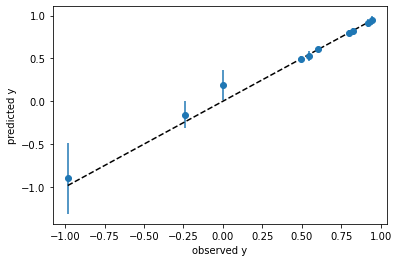

In [31]:
cross_validation(train_x,train_y)

We want to see that the error bar crosses the dashed line for most of the datapoints (95% of the datapoints), and when it misses it shouldn't miss by too much.  This plot looks pretty good.

#### Exercise 2 
    
Using the function below (which is -1 times a standard test function called Hartmann6),
and the 50 training points generated below (uniformly over the unit cube),
fit GP regression using a Matern kernel with nu=.5 and no noise in the observations,
Choose the hyperparameters by maximizing the log marginal likelihood.

Then plot a cross-validation plot.  You'll see that it looks ok, but some errobars are far from touching the line.  Based on this plot we might want consider another kernel or transforming the objective.

In [32]:
from botorch.test_functions import Hartmann
f = Hartmann(negate=True)

np.random.seed(1)
torch.manual_seed(1)
train_x = torch.rand(50, 6, device=device, dtype=dtype)
train_y = f(train_x).unsqueeze(-1)  # add output dimension

#### Exercise 2 Solution

In [33]:
noisefree_variance = 0.0001
noises = torch.ones(len(train_y)) * noisefree_variance
model = SingleTaskGP(train_x, train_y, likelihood = FixedNoiseGaussianLikelihood(noise=noises))
model.covar_module.base_kernel.nu = .5
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): FixedNoiseGaussianLikelihood(
    (noise_covar): FixedGaussianNoise()
  )
  (model): SingleTaskGP(
    (likelihood): FixedNoiseGaussianLikelihood(
      (noise_covar): FixedGaussianNoise()
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

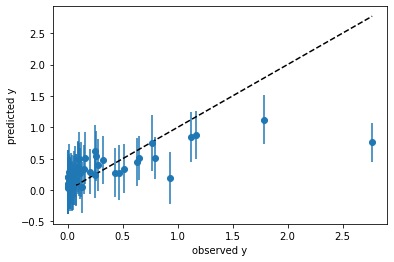

In [34]:
cross_validation(train_x,train_y,0.5) # Remember to pass nu=0.5